# Arthena Data Science Interview Task:

# John Elton

###  In the code below I address the problem of predicting the 'hammer price' of lots. The general approach is to train a regression model for predicting this price given the features in the data sets provided. The questions for parts 1 and 2 are answered below and are followed by the code used and various outputs produced. The final questions are answered at the end.

# Part 1:

### Did you perform any data cleaning, filtering or transformations to improve the model fit?

I filtered out the rows for which hammer_price is -1, as suggested. I also removed rows for which low_estimate or high_estimate is -1 or 0. This only cut the number of total rows down from 15,531 to 14,612.

Prices were normalized by dividing each hammer_price, low_estimate, and high_estimate by the exchange rate for the given currency.

Measurements for the size of the lot were converted to all be in centimeters.

An "average price of lots sold" was computed for each unique Timestamp, and this was used to compute two lags of the hammer_price. That is, for each row in the dataset, the first lag is given by the hammer_price for that row minus the average price of lots sold for the previous Timestamp.

I took the logarithm of the price fields and used this as the quantity to fit in the regression. The reasoning for this is explained below in the discussion about loss function.

### Why did you choose this model? 

The model chosen is a regularized (Lasso) multi-linear regression model using the following features:

['artist_birth_year','auction_lot_count','work_execution_year','work_height','work_width','estimate_low',
'estimate_high','artist_name','auction_house','auction_department','auction_location','work_medium','lag_1','lag_2']

Categorical features are one-hot encoded, resulting in a final dimensionality of 38. The data is split into training and testing sets, with all performance metrics calculated on the testing set.

A simple linear fit (on the logged prices) is justified by the strong results obtained, and by visualizations showing that this fit is valid. See output below showing a plot of y_prediced versus y_test, and similarly a plot of the residuals. The regularization parameter was chosen by testing a range of values and checking the R^2 of the fit on the test data. With the features used and the regularization chosen, the model obtains an R^2 of about 0.95.

### What loss function did you use? Why did you pick this loss function? 

I use square loss with L1 regularization on the log-y values. Copied from Sci-kit Learn: 

(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

In the problem statement we are asked to minimize the relative error of each lot. Sci-kit Learn does not seem to have a simple way to specify an arbitrary loss function for it's models, but a little algebra shows that using log(y) with the above loss function is actually essentially the same as minimizing relative error. That is primarily the reason for taking the log.
 

### Describe how your model is validated. What error metrics did you evaluate your model against? 

The primary metric used for asessing model fit was to compute the R^2 of the test-y values against the predictions that the trained model made on the test-X values. To avoid overfitting, the regularizarion parameter was adjusted so that weights of non-informative features were set to 0 by the Lasso. With the features used and the regularization chosen, the model obtains an R^2 of about 0.95.

The scatterplot of y-test versus the predicted values does not show a significant deviation from linearity, and the plot of residuals appears to be mostly homoscedastic (see plots in code outputs), so this helps to justify the use of the multi-linear regression.

### How does the time-series nature of your data affect how you trained and tested your model?

Since the sold prices of lots create a time series, we want to include that information in the model, since past sold prices may be useful for predicting future sales. One way to do this, as I have done, is to use an Autoregressive Distributed Lag (ADL) model. Essentially this just means computing several lags in the price variable and including these as additional features along with our other predictors, for which we will obtain a coefficient in the regression just as if it were a given feature. As mentioned above, I computed the average price of lots sold for each unique Timestamp and used this to create two lags. These are the features called 'lag1' and 'lag2' in the model.




# Part 2:

### a. Briefly discuss your approach to this problem. Pick a few of the lots that you generated `hammer_price` predictions for and do this. Do any of the distributions follow a familiar form? How does the variance differ between plots?

The approach here is to produce a distribution of possible y-values for a given X by simulating additional data through the process of bootstrapping. Our model produces a single point estimate of y, however since we also have the true y-values, we can compute residuals for every row of data. This gives us 3,653 residuals. Now, the linear regression model states that for each i, 

y_i = X_i*W + e_i

where e_i is the error or residual. And one of the assumptions for linear regression is that the residuals are i.i.d. (Normal in fact). Even though the price data itself is not i.i.d., this does not imply that the residuals can not be. Again, from the residual plot we see that the roughly equal variance assumption appears to hold. 

Now, assuming i.i.d. residuals, we bootstrap by sampling with replacement from the residuals and adding the sampled errors on to the true y value for a given point, creating a p.m.f. which can be displayed by a histogram.

I carry this out for three separate points, one for each artist. As we can see from the plots produced by this procedure below, 2 of the 3 the p.m.f's have a roughly Normal form, while one is more skewed. The variance looks roughly similar in the 3 plots.


###  b. Compare your `hammer_price` distributions to the global distribution of all `hammer_price`s. You may consider normalizing them by dividing by one of the estimates. How do they diverge from the global distribution? How confident are you in your results?

A histogram showing the normalized hammer_price distribution for all lots is shown below. Comparing to the single point distributions, the shape is similar (roughly Normal) but there is a wider spread. This is expected since this distribution of y's is for all different X's (variation of price for different inputs), as opposed to a distribtuion of y's for a single X ( a fluctuation around the expected value).


In [57]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None 


from sklearn.linear_model import Lasso

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Import the data
df_l = pd.read_csv('lewitt.csv')
df_p = pd.read_csv('picasso.csv')
df_w = pd.read_csv('warhol.csv')


N_l = df_l.shape[0]
N_p = df_p.shape[0]
N_w = df_w.shape[0]


df = pd.concat([df_l,df_p,df_w])

N = df.shape[0]

# Filter hammer_price = -1 (didn't sell)
df = df[df['hammer_price'] != -1]
# also filter estimate (only a few such records)
df = df[(df['estimate_low'] != -1) & (df['estimate_low'] != 0)]
df = df[(df['estimate_high'] != -1) & (df['estimate_high'] != 0)]
df= df.reset_index(drop=True)
N = df.shape[0]

# Normalize price to account for different currencies by dividing by exchange rate

df['hammer_price'] = df['hammer_price']/df['exchange_rate_to_usd']
df['estimate_low'] = df['estimate_low']/df['exchange_rate_to_usd']
df['estimate_high'] = df['estimate_high']/df['exchange_rate_to_usd']


# adjust work measurement values to account for different dimensions.
# convert everything to cm  (have mm, in, m)

df['work_height'] = df.apply(lambda row: row['work_height']*10 if row['work_measurement_unit'] == 'mm' else row['work_height']*0.01 if row['work_measurement_unit'] == 'm' else row['work_height']*0.3937 if row['work_measurement_unit'] == 'in' else row['work_height'],axis=1)
df['work_width'] = df.apply(lambda row: row['work_width']*10 if row['work_measurement_unit'] == 'mm' else row['work_width']*0.01 if row['work_measurement_unit'] == 'm' else row['work_width']*0.3937 if row['work_measurement_unit'] == 'in' else row['work_width'],axis=1)
df['work_depth'] = df.apply(lambda row: row['work_depth']*10 if row['work_measurement_unit'] == 'mm' else row['work_depth']*0.01 if row['work_measurement_unit'] == 'm' else row['work_depth']*0.3937 if row['work_measurement_unit'] == 'in' else row['work_depth'],axis=1)


# Convert date fields to Datetime object
df['auction_date'] = pd.to_datetime(df['auction_date'])

df = df.sort_values('auction_date',ascending = False)
df= df.reset_index(drop=True)

# Compute average price by day
price_ave = df.groupby(['auction_date'])['hammer_price'].mean()
df['price_day_avg'] = 0.0
for i in range(N):
    df['price_day_avg'][i] = price_ave[df['auction_date'][i]]


# compute lagged prices
daily_prices = np.array(price_ave.sort_index(ascending=False))

n_prices = len(daily_prices)
df['lag_1'] = 0.0
df['lag_2'] = 0.0
for i in range(N):
    ind = np.argwhere(daily_prices == df['price_day_avg'][i])[0][0]
    if ind == n_prices-1:
        df['lag_1'][i] = daily_prices[ind]
        df['lag_2'][i] = daily_prices[ind]
    elif ind == n_prices-2:
        df['lag_1'][i] = daily_prices[ind+1]
        df['lag_2'][i] = daily_prices[ind]
    else:
        df['lag_1'][i] = daily_prices[ind+1]
        df['lag_2'][i] = daily_prices[ind+2]
        

# Apply transformation of taking log of hammer_price (as well as estimate_low and estimate_high)

df['hammer_price'] = np.log(df['hammer_price'])
df['estimate_low'] = np.log(df['estimate_low'])
df['estimate_high'] = np.log(df['estimate_high'])

df['lag_1'] = np.log(df['lag_1'])
df['lag_2'] = np.log(df['lag_2'])


# peel off the labels column
labels = pd.DataFrame(df['hammer_price'])
df = df.drop('hammer_price',1)  

           
# Select only the features we will use

features = ['artist_birth_year','auction_lot_count','work_execution_year','work_height','work_width','estimate_low','estimate_high','artist_name','auction_house','auction_department','auction_location','work_medium','lag_1','lag_2']

df = df[features]

# one-hot encode categorical features with dummy columns, leaving one out for each
cols_to_transform = ['artist_name','auction_house','auction_department','auction_location','work_medium']


df_dummies = pd.get_dummies(data=df,columns = cols_to_transform,drop_first=True )
features_all = df_dummies.columns

# Scale the features to have mean 0, variance 1
scaler = StandardScaler()
df_dummies = scaler.fit_transform(df_dummies)


# Create test/train split
(trainX, testX, trainY, testY) = train_test_split(df_dummies, labels, test_size = 0.25, random_state = 34)
 

N_train = trainX.shape[0]
N_test= testX.shape[0]

# re-format labels for use with sklearn functions
trainY = trainY.values.reshape(N_train,)

In [58]:
# Modeling

# build Lasso Regression model
# Try range of alpha values for regularization constant
model =  Lasso(alpha = 0.01, random_state = 37)

model.fit(trainX,trainY)
predictions = model.predict(testX)

r_squared = model.score(testX, testY)
print('R-squared =  ', r_squared)

# print top coefficients
coeffs = list(zip(model.coef_, features_all))
coeffs = sorted(coeffs, key=lambda x: -abs(x[0]))
print('Top coefficients: ', coeffs[0:10])

R-squared =   0.950478829495
Top coefficients:  [(1.2933617437882752, 'estimate_low'), (0.5381253116582464, 'estimate_high'), (0.059566653728709021, 'work_medium_decorative arts'), (0.053601217660336861, 'auction_department_Impressionist & Modern'), (0.035617695447692096, 'artist_birth_year'), (-0.031432762642245024, 'auction_lot_count'), (0.017129299245514915, 'lag_1'), (-0.012934299976778306, 'auction_department_Prints & Multiples'), (-0.0094344339639297857, 'work_medium_drawing'), (0.0083105617326647424, 'lag_2')]


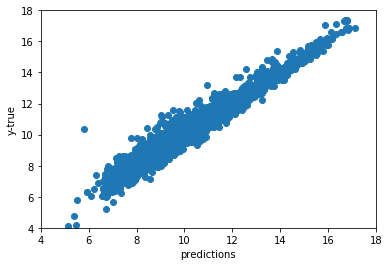

In [59]:
# Plot predicted versus true
plt.xlim(4,18)
plt.ylim(4,18)
plt.scatter(predictions, testY)
plt.xlabel('predictions')
plt.ylabel('y-true')
plt.show()

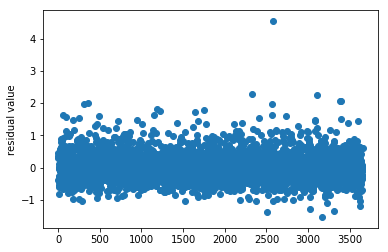

In [60]:
# Plot residuals
residuals = np.reshape(np.array(testY),N_test) - predictions
x_vec = np.arange(1,N_test+1,1)

plt.scatter(x_vec, residuals)
plt.ylabel('residual value')
plt.show()

# Part 2

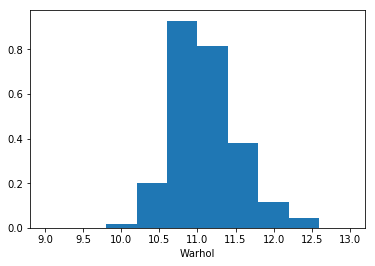

In [61]:
#############################################################################################
# Part 2
#############################################################################################

# Take bootstrap samples from the residuals to create distribution of y-values

# Select a particular X (i = 0 (Warhol), i = 8 (Lewitt),  i =  26 (Picasso) )
i_s = 0
s_size = 1000

y_base = predictions[i_s]
# Sample residuals with replacement
resid_sample =  np.random.choice(residuals,size = s_size, replace=True)

y_dist = y_base*np.ones(s_size)
y_dist = y_dist + resid_sample

# Histogram of possible y's for a given X
plt.hist(np.array(y_dist), range = (9,13), normed = True)
plt.xlabel('Warhol')
plt.show()

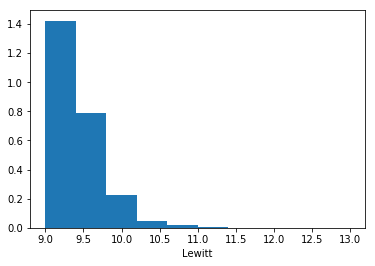

In [62]:
# Select a particular X (i = 0 (Warhol), i = 8 (Lewitt),  i =  26 (Picasso) )
i_s = 8
s_size = 1000

y_base = predictions[i_s]
# Sample residuals with replacement
resid_sample =  np.random.choice(residuals,size = s_size, replace=True)

y_dist = y_base*np.ones(s_size)
y_dist = y_dist + resid_sample

# Histogram of possible y's for a given X
plt.hist(np.array(y_dist), range = (9,13), normed = True)
plt.xlabel('Lewitt')
plt.show()

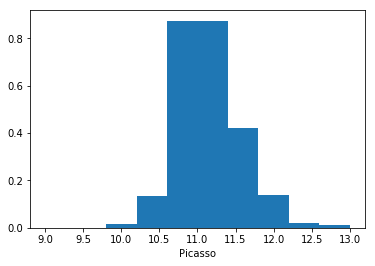

In [63]:
# Select a particular X (i = 0 (Warhol), i = 8 (Lewitt),  i =  26 (Picasso) )
i_s = 26
s_size = 1000

y_base = predictions[i_s]
# Sample residuals with replacement
resid_sample =  np.random.choice(residuals,size = s_size, replace=True)

y_dist = y_base*np.ones(s_size)
y_dist = y_dist + resid_sample

# Histogram of possible y's for a given X
plt.hist(np.array(y_dist), range = (9,13), normed = True)
plt.xlabel('Picasso')
plt.show()

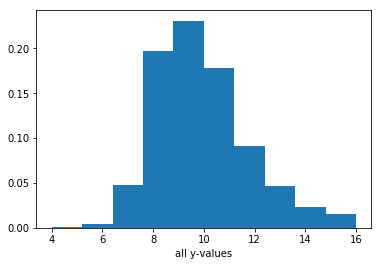

In [64]:
# Histogram of all y-values

plt.hist(np.array(labels), range = (4,16), normed = True)
plt.xlabel('all y-values')
plt.show()

# Additional Questions

### 1.)  Which features are most important for your model? Are there any features that surprised you? Given more data, describe other features you feel would be useful in improving the accuracy of your model.

After standardizing the features, one of the outputs produced above is a list of the top coefficients of the model. This is a measure of feature importance. Overwhelmingly the stronget predictors turned out to be estimate_low followed by estimate_high. This is not terribly surprising. Some other features that were relevant are work_medium, auction_location, and lagged price. Auction location and lagged price are also not surprising and I would have actually expected lagged price to be even more important. However the simple method used of averaging the price over each Timestamp probably did not capture the most useful lag information. I believe a lot more could go into this, such as using the order of lots in the auction and only using lagged values for lots that are 'similar' to the one in question.



### 2.)  Suppose we're tasked with evaluating the price of a work where we're given an incomplete set of features. Say, we're given the artist name, type of work, and size, but we know nothing else. How would you go about estimating the `hammer_price` at an auction tomorrow?

Assuming that we had already built a strong model with a large amount of complete data and that it is only a new work with an incomplete set of features that we want to estimate, I would take the features for the new work (artist name, type of work, size) and try to find examples of other pieces of art which are very similar in these few features, and see what these similar works sold for. Another approach would be even to estimate values for the missing features (either using some kind of average or a common sense guess) and then just plug these values into one or several of the models to get a rough estimate.


### 3.)  Assume we care much more about not overpredicting `hammer_price` than we do about underpredicting the price. Describe how you would go about changing your solution in terms of the model, objective function, etc.

For this question, I would need to take a different approach to the objective function than the choice of using log(price) to minimize relative error. A possible solution would be to use "Weighted Least Squares", where different weights could be used for errors which overestimate from those which underestimate the price. In that way we could choose the weights so as to penalize over-predicting as strongly as we want. The only downside is that we would need to write our own optimization routine or else switch to another library which allows relative error with weights to be used in the loss function.

### 4.)  Given more time, but no new features, how much do you think you could improve the accuracy of your models by? Why?

Without more data, probably not a lot. The fit is already quite strong and seems to be dominated by the low and high estimates, so any additional improvements by more clever feature creatiion or parameter tuning, I would not expect to have an exceptionally large effect.


### 5.)  Was this fun? Which sections / questions were the most difficult and which were the easiest?

I enjoyed thinking about the time-series aspect of this problem, which made it a little different from common regression/classification problems. Section 2 was also interesting to think about. I initially thought the question was hinting at a Bayesian Regression approach, but later decided the bootstrapping method was more what was intended.

